# 6 - Excitation transfer in more detail

**INTRODUCTION OF TERMINOLOGY: TLS (Two level system) used interchangeably with of TSS (Two state system)**


Last time, we added just one extra TLS and we got some surprising new physics - non-radiative excitation transfer. Excitations can move from one TLS to another without the emission and absorption processes that one would normally consider essential.

In this tutorial, we'll try and develop some intuition for excitation transfer by experimenting with different TLS parameters. From this, we'll get a sense of how excitation transfer times scale and thus how likely it would be to observe this phenomenon in real life systems.

Spolier alert, we're going to see that excitation transfer is a particularly sensitive little thing.

In [254]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *

from scipy.optimize import minimize_scalar
from scipy.stats import linregress

# The helper file below brings functions created in previous tutorials and adds an extra one
from libs.helper_06_tutorial import *

## 6.1 - Recap

Towards the end of the last tutorial, we motivated that a helpful way to write the Hamiltonian is

$$H =  \Delta E J_{Nz} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)2J_{Nx}$$

where:

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TLS:

$$J_{Nx} = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_{Ny} = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_{Nz} = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$

This angular momentum description is going to be invaluable for investigating many identical TLS in future tutorials. For this tutorial, however, we're going to be interested in a version of the Hamiltonian that allows us to adjust the characteristics of the individual TLS. We'll therefore work with the more verbose (but more flexible) Hamiltonian of the form:

$$H =  \frac{\Delta E_1}{2} \sigma_{z1} + \frac{\Delta E_2}{2}\sigma_{z2} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U_1\left( a^{\dagger} + a \right)\sigma_{x1} + U_2\left( a^{\dagger} + a \right)\sigma_{x2}$$

for which we can use the following `make_operators` function from the last tutorial:

In [262]:
def make_operators(max_bosons, parity=0):
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 
    
    J     = jspin(2, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                               # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                               # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])  # tensorised J^2 operator
    
    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        P               = P.extract_states(p)
        J2              = J2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]

    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list

The most obvious features we can play with here are:
- $\Delta E_1$ & $\Delta E_2$
- $U_1$ & $U_2$

Let's explore

## 6.2 - Matched TLS

The simplest way to explore excitation transfer is to "match up" the TLS $\Delta E_1 = \Delta E_2 = \Delta E$ and $U_1 = U_1 = U$.

$$H =  \frac{\Delta E}{2} (\sigma_{z1} + \sigma_{z2}) + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_{x1} + \sigma_{x2})$$


In [263]:
H_latex = "$H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

 In other words, we have identical TLS that interact with the boson field in the same way. This is the same set up as in the last tutorial, only now we're going to see how the excitation transfer time depends on $\Delta E$ and $U$.



Let's set the boson energy to be $\omega = 1$ as we've done in previous tutorials.

In [259]:
omega = 1

We'll increase the coupling from last time to $U = 0.1$ to make our explorations easier from a computational perspective.

In [400]:
U = 0.1

And we'll focus on even parity

In [401]:
parity = 1

Let's start by looking at $\Delta E$ and then $U$.

### $\Delta E$ scaling



In general, it's not possible to simply vary $\Delta E$ continuously across large range and look at how long it takes for e.g. $|1,+, - \rangle$ to transform into $|1,-, + \rangle$. The reason is that "excitation transfer" cannot be totally separated from  what we might call `energy exchange`. 

Energy exchange occurs when $\Delta E = n\omega$. That's when spontaneous emission and down convertsion can occur. Close to those "resonances", energy exchange dominates over excitation transfer.

We can however, artificially suppress the energy exchange resonances by limiting the number of bosons in the system to 2. We can motivate that this is a good approximation by referring to the Hinton diagram (Fig 3) from the [last tutorial](https://nbviewer.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb).

$|1,+, - \rangle $ is coupled to 4 other states (i.e. they have non-zero matrix elements):
- $|0,+, + \rangle $
- $|0,-, - \rangle $
- $|2,+, + \rangle $
- $|2,-, - \rangle $


and those states are then coupled to the final state $|1,-, + \rangle $. In that sense, we say $|1,+, - \rangle $ is indirectly coupled to $|1,-, + \rangle $.

> It is interesting to observe that the excitation transfer between $|1,+, - \rangle $ and $|1,+, - \rangle $ involves states that appear to violate our usual sense of conservation of energy. For example, the state $|2,+, + \rangle $ has an extra boson and an extra excitation in the TSS compared to $|1,+, - \rangle $. These are called `virtual states`.

We can therefore expect that the most important states contributing to the excitation transfer process can be captured by setting `max_bosons=2` (so long as the coupling is weak).

In [402]:
max_bosons = 2

In [403]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)

In [404]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E$", 0, 200, 2001, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

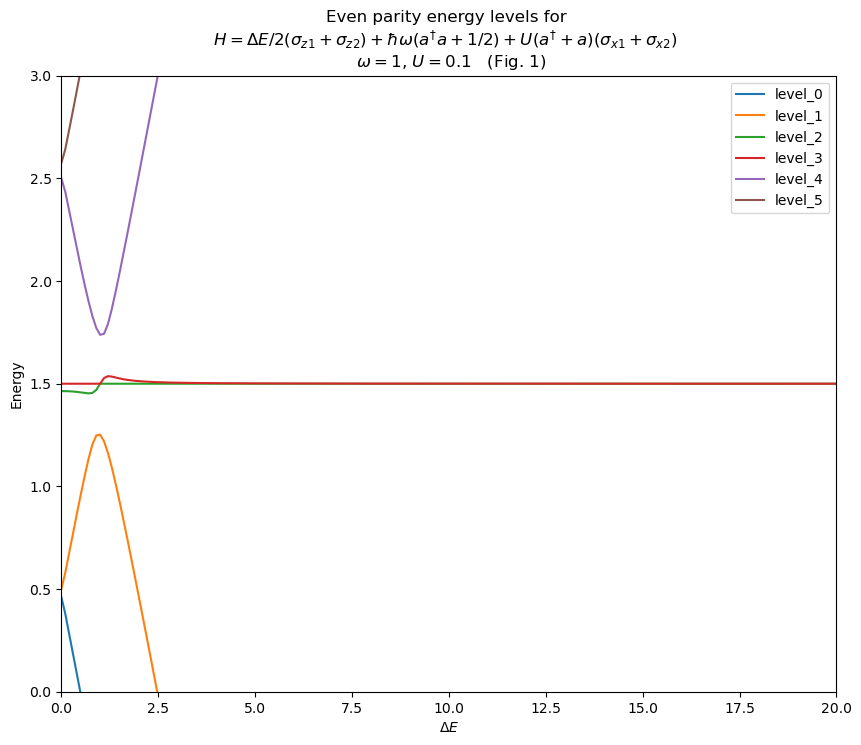

In [405]:
df_even.plot(x="$\Delta E$",ylim=[0,3],xlim=[0,20], legend=True, 
        title=f"Even parity energy levels for \n {H_latex}  \n $\omega={omega}$, $U={U}$   (Fig. 1)",
             figsize=(10,8));

plt.ylabel("Energy");


Fig. 1 shows us 4 levels coming together at $\Delta E = 1$ - we explored this situation last time where $|1,+, - \rangle \rightarrow |1,-, + \rangle$ through the intermediate states $|0,+, + \rangle$ and $|2,-, - \rangle$. In that case, energy can be exchanged between the TLS and the boson field because they have the same energy.


Non-radiative excitation transfer does not occur around $\Delta E = 1$ because of the energy exchange resonance that occurs there.

> You might be wondering why we don't have the same 4 level crossing at the down conversion resonances $\Delta E = 3, 5, 7$ and so on. In reality we do, but we have suppressed that physics by setting max_bosons = 2

Away from $\Delta E = 1$, excitation transfer can be understood as as result of frequency beating between levels 2 and 3 as we showed last time. To calculate the excitation transfer time, we therefore need to do: 

$$T = \frac{2 \pi}{E_\text{level 3} - E_\text{level 2} }$$

for all the different $\Delta E$.

In [406]:
df_even23 = df_even[["$\Delta E$", "level_2", "level_3"]] # Only keep levels 2 and 3

In [407]:
# Discard DeltaE < 2.5 so that we don't include effects from the energy resonance at DeltaE=1
df_even23 = df_even23[df_even23["$\Delta E$"]>=2.5] 

In [408]:
# Calculate the excitation transfer time
df_even23["Time"] = 2*np.pi / (df_even23["level_3"] - df_even23["level_2"]) 

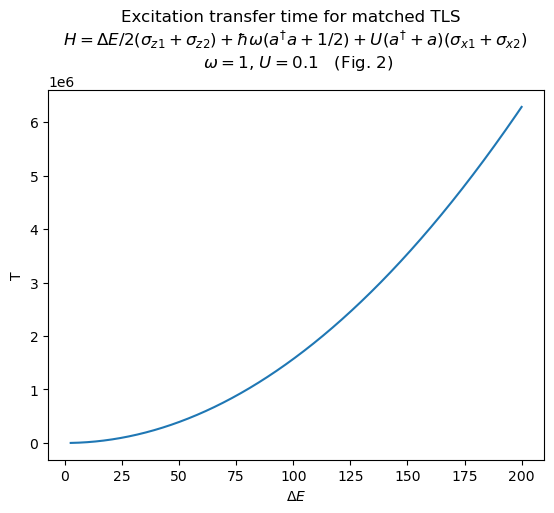

In [409]:
df_even23.plot(x="$\Delta E$",y="Time", title=f"Excitation transfer time for matched TLS  \n {H_latex} \n $\omega=1$, $U=0.1$   (Fig. 2)", legend=False);
plt.ylabel("T"); 

The plot looks polynomial in nature. Let's verify this by viewing it in as a log-log plot.

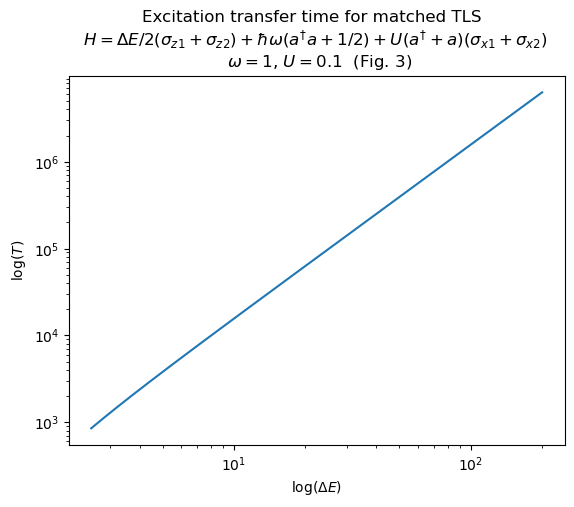

In [410]:
df_even23.plot(x="$\Delta E$",y="Time",logx = True, logy = True, title=f"Excitation transfer time for matched TLS  \n {H_latex} \n $\omega=1$, $U=0.1$  (Fig. 3)", legend=False);
plt.xlabel("$\log(\Delta E)$")
plt.ylabel("$\log(T)$");

The straight line in Fig. 3 is highly suggestive of $T \sim \Delta E ^x$ Let's look at the gradient of this line to find $x$.

In [411]:
linregress(np.log10(df_even23["$\Delta E$"]), np.log10(df_even23["Time"])).slope

2.0060139454941455

We've got a quadratic relationship between TLS transition energy and excitation transfer time $T \sim \Delta E ^2$. In other words, if we increase the TLS transition energy by a factor of 10 compared to the boson energy $\omega$, then the excitation transfer time goes up by a factor of 100.

It's worth remembering that we've suppressed all the energy exchange resonances to extract this scaling. Close to $\Delta E = n \omega$ this scaling therefore won't make sense. Nevertheless the scaling is still helpful for us to get a sense of how weak the excitation transfer becomes as $\Delta E$ increases.

### $U$ scaling

Let's perform the same analysis for varying the coupling strength. We'll fix $\Delta E = 2.5$

In [417]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$U$", 0.01, 0.2, 2001, interaction_1.shape[0])

for i, row in df_even.iterrows():
    H =  2.5*two_state_1+ 2.5*two_state_2 + omega*bosons + row["$U$"]*interaction_1 + row["$U$"]*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

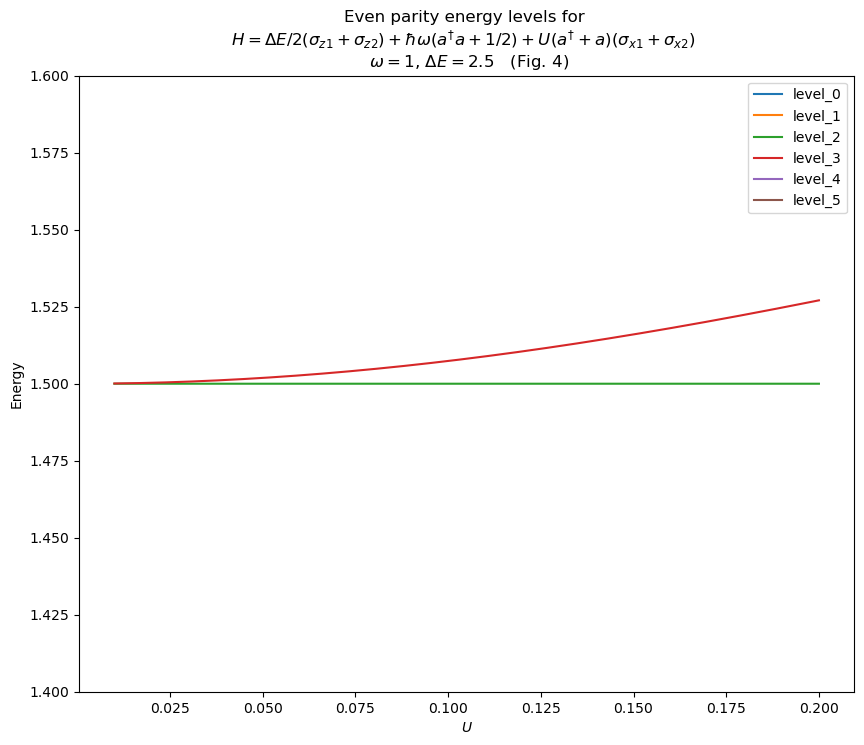

In [418]:
df_even.plot(x="$U$",ylim=[1.4,1.6], legend=True, 
        title=f"Even parity energy levels for \n {H_latex}  \n $\omega={omega}$, $\Delta E=2.5$   (Fig. 4)",
             figsize=(10,8));

plt.ylabel("Energy");


In [419]:
df_even23 = df_even[["$U$", "level_2", "level_3"]] # Only keep levels 2 and 3

In [420]:
# Calculate the excitation transfer time
df_even23["Time"] = 2*np.pi / (df_even23["level_3"] - df_even23["level_2"]) 

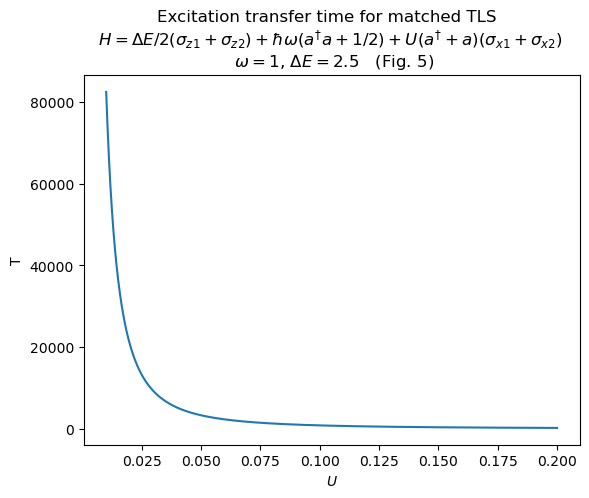

In [422]:
df_even23.plot(x="$U$",y="Time", title=f"Excitation transfer time for matched TLS  \n {H_latex} \n $\omega={omega}$, $\Delta E=2.5$   (Fig. 5)", legend=False);
plt.ylabel("T"); 

Much like Fig. 2,  Fig. 5 also looks polynomial in nature, but with a negative power this time. Let's verify this by viewing it in as a log-log plot.

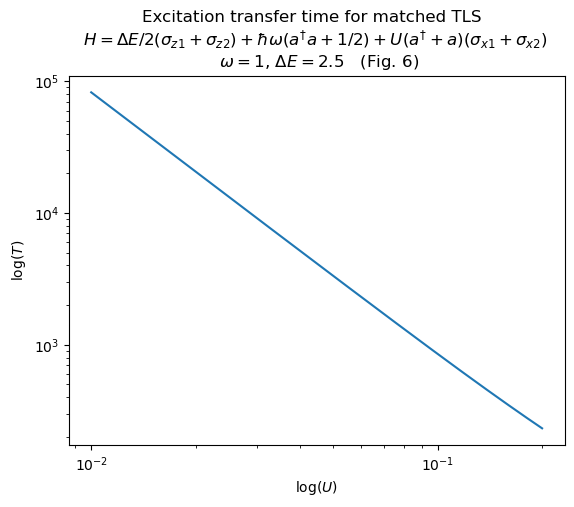

In [425]:
df_even23.plot(x="$U$",y="Time",logx = True, logy = True, title=f"Excitation transfer time for matched TLS  \n {H_latex} \n $\omega={omega}$, $\Delta E=2.5$   (Fig. 6)", legend=False);
plt.xlabel("$\log(U)$")
plt.ylabel("$\log(T)$");

A nice straight line downwards confirms our suspicion. Now let's check out the slope:

In [426]:
linregress(np.log10(df_even23["$U$"]), np.log10(df_even23["Time"])).slope

-1.9573170306767869

We've got an inverse quadratic relationship between coupling strength and excitation transfer time $T \sim U ^{-2}$.

When we combine the two scalings we reproduce the 2008 analytical findings from [Hagelstein](http://dx.doi.org/10.1088/0953-4075/41/13/135501) that excitation transfer time scales like:

$$T \sim \left(\frac{\Delta E}{U}\right)^2$$

when the two TLS are matched.

What happens when the systems are not matched?

## 6.3 - Mismatched TLS

Let's start by giving the TLS different transition energies but we'll keep the coupling the same for each. In other words:

$$H =  \frac{\Delta E_1}{2} \sigma_{z1} + \frac{\Delta E_2}{2}\sigma_{z2} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_{x1} + \sigma_{x2})$$


In [436]:
H_latex = "$H = (\Delta E_1 /2) \sigma_{z1} + (\Delta E_2 /2) \sigma_{z2} + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

Let's again work with $U=0.1$

In [437]:
U=0.1

We'll fix $\Delta E_2 = 2.5$ and scan through $\Delta E_1$ to look at the energy level landscape

In [438]:
DeltaE2 = 2.5

In [439]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E_1$", 0, 200, 2001, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E_1$"]*two_state_1+ DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

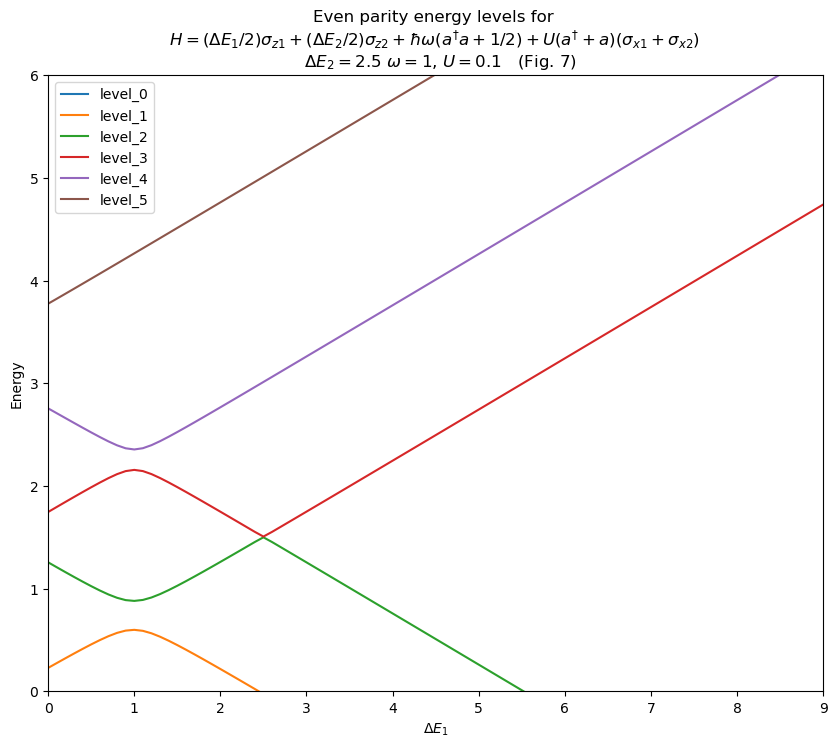

In [440]:
df_even.plot(x="$\Delta E_1$",ylim=[0,6],xlim=[0,9], legend=True, 
        title=f"Even parity energy levels for \n {H_latex} \n  $\Delta E_2={DeltaE2}$ $\omega={omega}$, $U={U}$   (Fig. 7)",
             figsize=(10,8));

plt.ylabel("Energy");


Fig. 7 shows us energy exchange resonances at $\Delta E_1 = 1$. This is when the boson energy matches TLS_1 and we get exhange of energy between the TLS and the boson field. In that case, TLS_2 is not involved in the dynamics at all because its transition energy ($\Delta E_2=2.5$) is not matching either the boson energy of the transition energy of TLS_2.

When $\Delta E_1 = 2.5$, we have matched transition energies between TLS_1 and TLS_2. As we've already explored, we know that excitation transfer occurs here. What's new from this plot is that we can see the visual signature that we've come to expect when interesting physics happens, namely an anti-crossing between levels 2 and 3. Let's check this because on this scale we can't really see it. 

We'll create a function to calculate the level differences just like we did last time.

In [441]:
def level_difference(DeltaE, DeltaE2, omega, U1, U2, level_number):
    H = DeltaE*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U1*interaction_1 + U2*interaction_2
    evals, ekets = H.eigenstates()
    return np.abs(evals[level_number] - evals[level_number-1])

We'll also make a function to help us create sensible ranges for our anti-crossing plots. This function aims to put the anti-crossing in the middle of the plot.

In [448]:
def plot_anti_crossing(DeltaE1, DeltaE2, omega, U, level, anti_crossing_energy, splitting):
    df = make_df_for_energy_scan("$\Delta E_1$", DeltaE1-2*splitting, DeltaE1+2*splitting, 201, two_state_1.shape[0])

    for i, row in df.iterrows():
        H =  row["$\Delta E_1$"]*two_state_1+ DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
        evals, ekets = H.eigenstates()
        df.iloc[i,1:] = evals
        
    ax = df.plot(x="$\Delta E_1$",figsize=(10,8),ylim=[anti_crossing_energy-2*splitting, anti_crossing_energy+2*splitting], 
        title=f"Even parity energy levels for \n {H_latex} \n  $\Delta E_2={DeltaE2}$ $\omega={omega}$, $U={U}$");
    ax.set_ylabel("Energy");
    return ax



Let's once again employ [`minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) to find the precise anti-crossing point by looking for the minimum energy level splitting. We do this because the dynamics around resonance can in general be very sensitive.


Maximum number of iterations exceeded
 message: 
          Maximum number of iterations exceeded
 success: False
     fun: 0.007386154431794356
       x: 2.50002575480924
     nit: 400
    nfev: 405


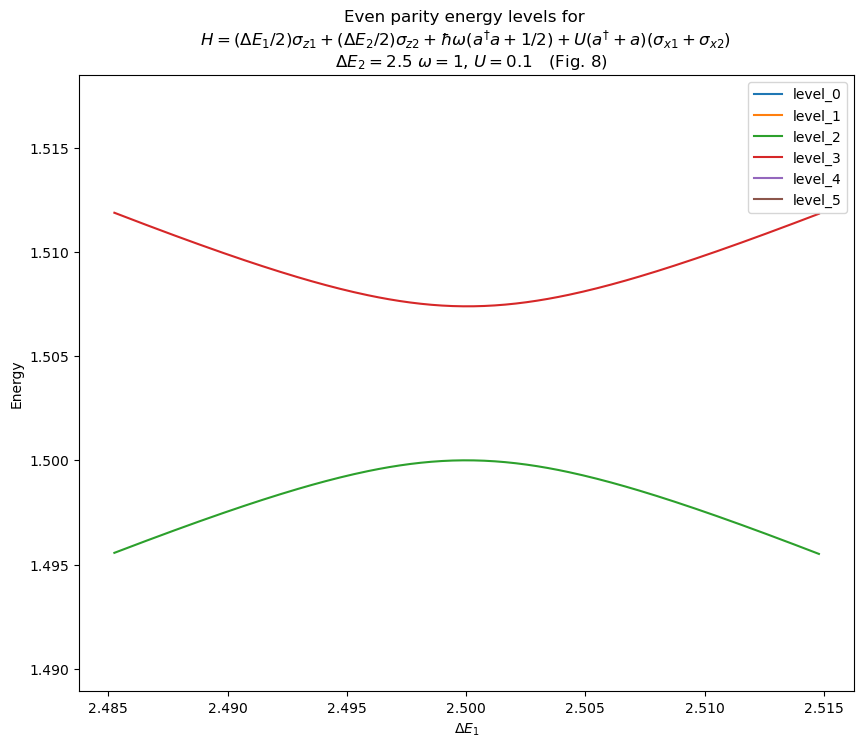

In [450]:
DeltaE1 = 2.5 # This is our starting guess for the DeltaE1 
DeltaE2 = 2.5
level = 3

# We are using method Golden with low tolerance in order to have best chance of detecting small anticrossings
anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400,"disp":True}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
print(anti_crossing)

H = anti_crossing.x*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
evals, ekets = H.eigenstates()

splitting = evals[level] - evals[level-1]
anti_crossing_energy = (evals[level] + evals[level-1])/2

ax = plot_anti_crossing(anti_crossing.x, DeltaE2, omega, U, level, anti_crossing_energy, anti_crossing.fun)
ax.set_title(f"{ax.get_title()}   (Fig. 8)");

Fig. 8 shows us how excitation transfer can be thought of as a kind of resonance just like energy exchange resonances that we've explored before.

We can see more physics if we increase `max_bosons` from 2 to 4.

In [451]:
max_bosons = 4
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)

In [452]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E_1$", 0, 200, 2001, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E_1$"]*two_state_1+ DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

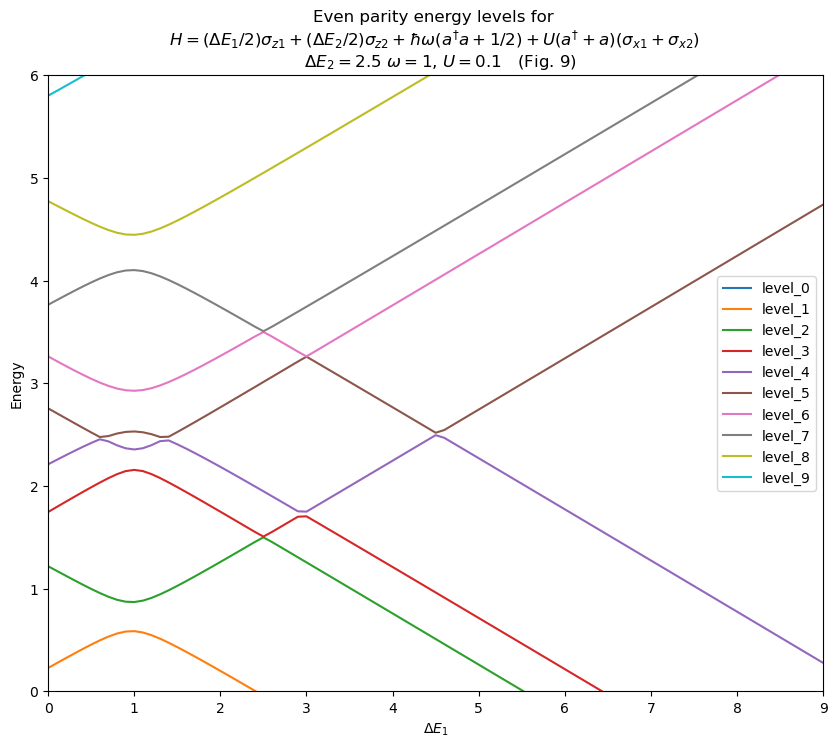

In [453]:
df_even.plot(x="$\Delta E_1$",ylim=[0,6],xlim=[0,9], legend=True, 
        title=f"Even parity energy levels for \n {H_latex} \n  $\Delta E_2={DeltaE2}$ $\omega={omega}$, $U={U}$   (Fig. 9)",
             figsize=(10,8));

plt.ylabel("Energy");


There are several new things to talk about in Fig. 9.

At $\Delta E_1 = 3$ we've got an anti-crossing associated with down conversion between levels 3 and 4. This is where TLS_1 transitions and the energy is converted into 3 bosons. We explored this in [Tutorial 04](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb).

At $\Delta E_1 = 4.5$, we've got another anti-crossing between levels 4 and 5. What's going on here? Let's first get a zoomed in view to check that it's a genuine anti-crossing.


Maximum number of iterations exceeded
 message: 
          Maximum number of iterations exceeded
 success: False
     fun: 5.4162078174435635e-05
       x: 4.5237004727858885
     nit: 400
    nfev: 405


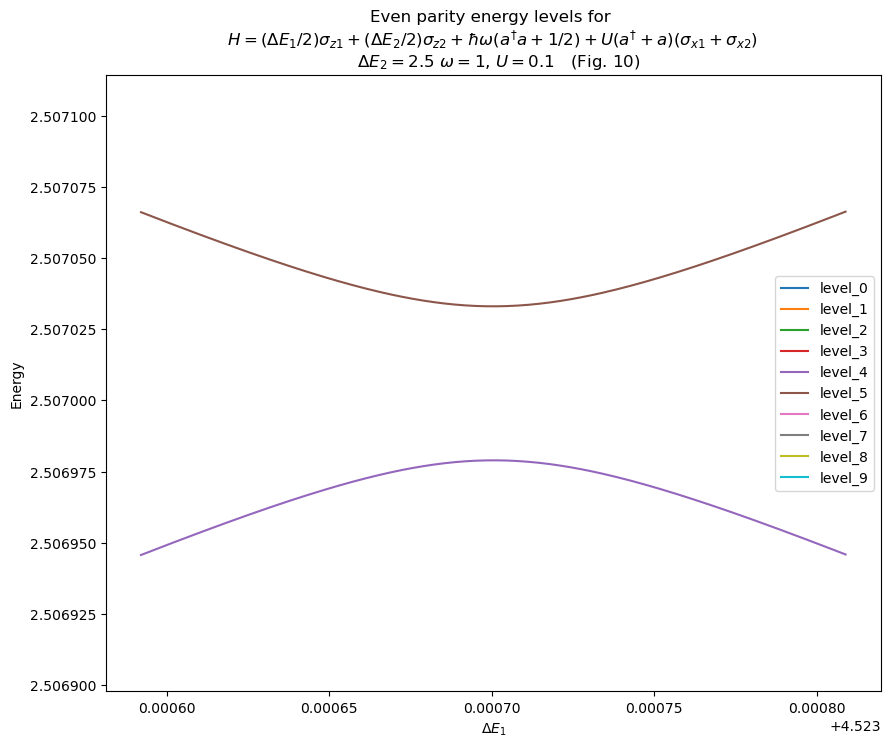

In [457]:
DeltaE1 = 4.5 # This is our starting guess for the DeltaE1 
DeltaE2 = 2.5
level = 5

# We are using method Golden with low tolerance in order to have best chance of detecting small anticrossings
anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400,"disp":True}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
print(anti_crossing)

H = anti_crossing.x*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
evals, ekets = H.eigenstates()

splitting = evals[level] - evals[level-1]
anti_crossing_energy = (evals[level] + evals[level-1])/2

ax = plot_anti_crossing(anti_crossing.x, DeltaE2, omega, U, level, anti_crossing_energy, anti_crossing.fun)
ax.set_title(f"{ax.get_title()}   (Fig. 10)");

Although, we're not quite sure what new physics is represented by the anti-crossing in Fig. 10, we've have come to expect rabi like oscillations on a timescale associated with the level difference at such an anti-crossing.

In [459]:
rabi_time = 2*np.pi/anti_crossing.fun

Let's run a simulation for 3 times this `rabi_time` and see what we get if we start things off in the $|1,+, - \rangle$ state just like we did in the last tutorial.

A reminder, $|1,+, - \rangle$ corresponds to state number 2 in QuTip's way of enumerating the states.

In [460]:
nmm_list[2]

(1, '+', '-')

In [461]:
psi0 = basis(len(nmm_list), 2)
times = np.linspace(0.0, rabi_time*3, 10000)
P, psi = simulate(H, psi0, times)

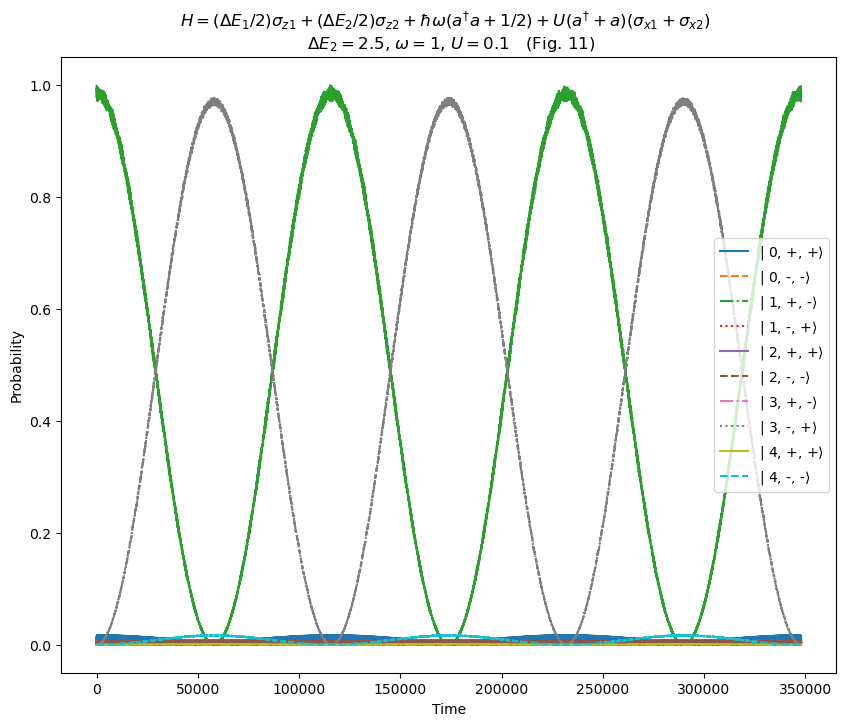

In [464]:
bra_labels, ket_labels = make_braket_labels(nmm_list)
plot_prob(P ,times, ket_labels)
plt.title(f"{H_latex} \n $\Delta E_2 = {DeltaE2}$, $\omega={omega}$, $U={U}$   (Fig. 11)");

Fig. 11 shows us a kind of hybrid between radiative and non-radiative excitation transfer. Although the TLS transition energies are not matched ($\Delta E_1 - \Delta E_2 = 2$), the excitation can move from TLS_1 to TLS_2 by emitting a number of bosons to make up the energy difference. In this case, 2 bosons are emitted which allows us to Rabi osscilate between $|1,+, - \rangle $ and $|3,-, + \rangle $. 

> Side note, this resonance is very sensitive, try re-running the simulation with `H = 4.5*two_state_1 + 2.5*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2` and you'll find no excitation transfer at all


You might be wondering why we didn't see this kind of behaviour when $\Delta E_1 - \Delta E_2 = 1$. In other words, why can't 1 boson be emitted to make up the energy difference? This is because of parity conservation. When we have energy exchange resonances, an odd number of bosons must be emitted, but for excitation transfer if must be an even number.

We should therefore expect to find other excitation transfer resonance when $\Delta E_1 - \Delta E_2 = 4, 6, 8$ etc. We'll need to keep increasing the number of bosons in order to explore these.

Let's try and automate the process of extracting the excitation transfer time when the mismatch in the transition energies of the TLS is $0\omega, 2\omega, 4\omega, 6\omega, 8 \omega$.

For this, we'll need to create a function to find the 2 levels associated with the anti-crossing.

In [465]:
def find_crossing_level(DeltaE1, DeltaE2, omega, U1, U2, tol):
    H = DeltaE1*two_state_1 + DeltaE2*two_state_2 + omega*bosons + U1*interaction_1 + U2*interaction_2
    evals, ekets = H.eigenstates()
    return np.argmax(np.diff(evals) < tol) + 1 # finds the first pair of levels that are closer together than "tol" apart

In [466]:
bosons_emitted = [0,2,4,6,8]
DeltaE2 = 2.5
U = 0.1

transfer_times = [] # Empty list to hold the excitation transfer times


for i, bos in enumerate(bosons_emitted):
    max_bosons = bos+2 # Final state is |1+bos,-,+>, we need to include one more boson above this state to capture all the non-zero matrix elements in the hamiltonian 
    two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)
    
    DeltaE1 = DeltaE2 + bos # set the mismatch to be even number of bosons
    level = find_crossing_level(DeltaE1, DeltaE2,omega, U, U, 0.1)
    
    # We are using method Golden with low tolerance in order to have best chance of detecting small anti-crossings
    anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
    transfer_times.append(2*np.pi/anti_crossing.fun)

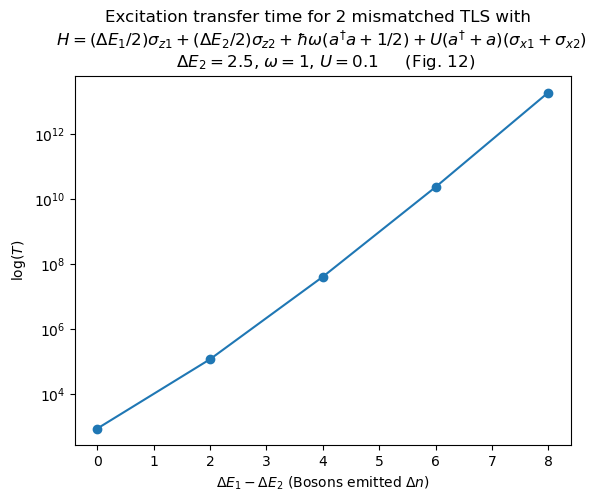

In [476]:
transfer_times_df = pd.DataFrame(data={"bosons":bosons_emitted, "times":transfer_times})
ax = transfer_times_df.plot(x="bosons",y="times", logy = True, title=f"Excitation transfer time for mismatched TLS with  \n {H_latex} \n $\Delta E_2=2.5$, $\omega=1$, $U=0.1$     (Fig. 12)", legend=False, style='o-');
ax.set_xlabel("$\Delta E_1 - \Delta E_2$ (Bosons emitted $\Delta n$)");
ax.set_ylabel("$\log(T)$");

In Fig. 12, each data point represents a fixed $\Delta E_2 = 2.5$ but a changing $\Delta E_1=2.5, 4.5, 6.5, 8.5, 10.5$. The mismatch between TLS_1 and TLS_2 can also be thought of in terms the number of bosons emitted ($\Delta n$) during the excitation transfer event. $\Delta E_1 - \Delta E_2 = 0$ is the matched case and $\Delta E_1 - \Delta E_2 = 2$ is the case we simulated in Fig. 11 where 2 bosons were emitted as part of the excitation transfer.

You'll notice that Fig. 12 has the excitation transfer time plotted on a log scale. A straight line in such a plot is a signature of an exponential relationship:

$$T \sim C^{\Delta n}$$

where $\log\left(C\right)$ comes from the gradient of the log plot

In [478]:
linregress(transfer_times_df["bosons"], np.log10(transfer_times_df["times"])).slope

1.3001654307591886

and so in this case we have 

$$T \sim 20^{\Delta n}$$

But where does this 20 number come from? Is it universal? Is it related to our parameters somehow? Let's allow both $\Delta E_1$ and $\Delta E _2$ to vary and check.

In [706]:
 # We won't go too high in boson number or DeltaE2 due to the very long excitation transfer times that become too difficult to measure accurately
bosons_emitted = [0,2,4]
DeltaE2s = [2.5, 10.5, 20.5, 30.5, 40.5, 50.5, 60.5]
U=0.1

transfer_times_obj = {} # empty object that will be filled with values and eventually be turned into a dataframe
transfer_times_obj["bosons"] = bosons_emitted

for j, DeltaE2 in enumerate(DeltaE2s):

    transfer_times = [] # Empty list to hold the excitation transfer times

    for i, bos in enumerate(bosons_emitted):
        max_bosons = bos+2 # Final state is |1+bos,-,+>, we need to include one more boson above this state to capture all the non-zero matrix elements in the hamiltonian 
        two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)
        
        DeltaE1 = DeltaE2 + bos # set the mismatch to be even number of bosons
        level = find_crossing_level(DeltaE1, DeltaE2, omega, U, U, 0.1)
        
        # We are using method Golden with low tolerance in order to have best chance of detecting small anti-crossings
        anti_crossing = minimize_scalar(level_difference, args=(DeltaE2, omega, U, U, level), options={"maxiter":400}, tol=1e-20, method="Golden", bracket=[DeltaE1-0.25, DeltaE1+0.25])
        transfer_times.append(2*np.pi/anti_crossing.fun)

    transfer_times_obj[DeltaE2] = transfer_times

transfer_times_df = pd.DataFrame(data=transfer_times_obj)

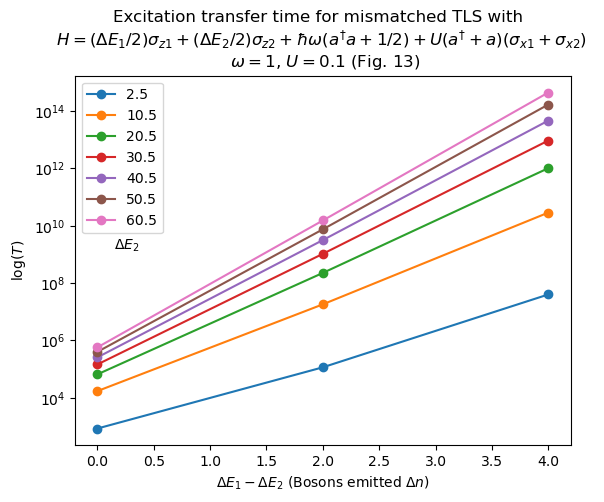

In [731]:
ax = transfer_times_df.plot(x="bosons", logy = True, title=f"Excitation transfer time for mismatched TLS with  \n {H_latex} \n $\omega=1$, $U=0.1$ (Fig. 13)", legend=True, style='o-');
ax.set_xlabel("$\Delta E_1 - \Delta E_2$ (Bosons emitted $\Delta n$)");
ax.set_ylabel("$\log(T)$");
plt.annotate('$\Delta E_2$', xy=(0.15, 1.5*10**9));

The gradients in Fig. 13 are not the same - this tells us that the $C=20$ in $T \sim C^{\Delta n}$ is not universal. It also tells us that the gradient depends on the $\Delta E$'s, but how?

If we look at Fig. 13, we can see that as we increase the $\Delta E$'s, the gradients increase but less so for higher values of $\Delta E$'s compared to lower. That behaviour is a hallmark of the $\log$ function. We might therefore conjecture that the gradient $\log\left(C\right) = \log\left(\Delta E\right)$ and so $C \sim \Delta E$ where $\Delta E = \left(\Delta E_1 + \Delta E_2\right)/2$. Futhermore, we might also conjecture that $T \sim \Delta E^{2+ \Delta n}$ to align with the scaling we found earlier when we have matched TLS and $\Delta n=0$. 

If we take each of the lines in Fig. 13 and divide them by $\Delta E^{2+ \Delta n}$ and they all end up on top of each other, then we can say that our conjecture is true. 


In [722]:
scaled_transfer_times_df = transfer_times_df.copy()

for index, row in scaled_transfer_times_df.iterrows():
    for DeltaE2 in DeltaE2s:
        scaled_transfer_times_df.loc[index, DeltaE2] /= ((DeltaE2+row["bosons"]+DeltaE2)/2)**(2+row["bosons"])

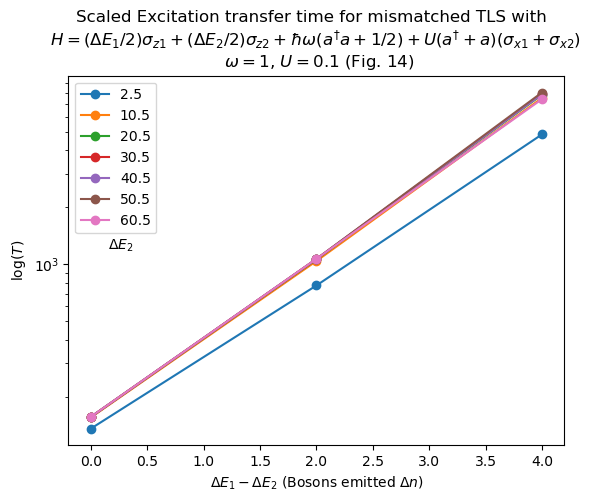

In [736]:
ax = scaled_transfer_times_df.plot(x="bosons", logy = True, title=f"Scaled Excitation transfer time for mismatched TLS with  \n {H_latex} \n $\omega=1$, $U=0.1$ (Fig. 14)", legend=True, style='o-');
ax.set_xlabel("$\Delta E_1 - \Delta E_2$ (Bosons emitted $\Delta n$)");
ax.set_ylabel("$\log(T)$");
plt.annotate('$\Delta E_2$', xy=(0.15, 1.2*10**3));

Other than for $\Delta E_2 = 2.5$, The scaling $T \sim \Delta E^{2+ \Delta n}$ does a good job of explaining the differences between excitation transfer times when varying TLS transition energy.

There is however still some significant dependency on $\Delta n$ that's not being captured by the $\Delta E$ scaling we've found. In other words, the lines aren't horizontal. In the spirit of connecting to our earlier scalings with 2 matched TLS, we can try adding the coupling:  

$$T \sim \left(\frac{\Delta E}{U}\right)^{2+\Delta n}$$

Let's check this.

In [764]:
scaled_transfer_times_df = transfer_times_df.copy()

for index, row in scaled_transfer_times_df.iterrows():
    for DeltaE2 in DeltaE2s:
        scaled_transfer_times_df.loc[index, DeltaE2] /= ((DeltaE2+row["bosons"]+DeltaE2)/2/(np.sqrt(1)*U))**(2+row["bosons"])

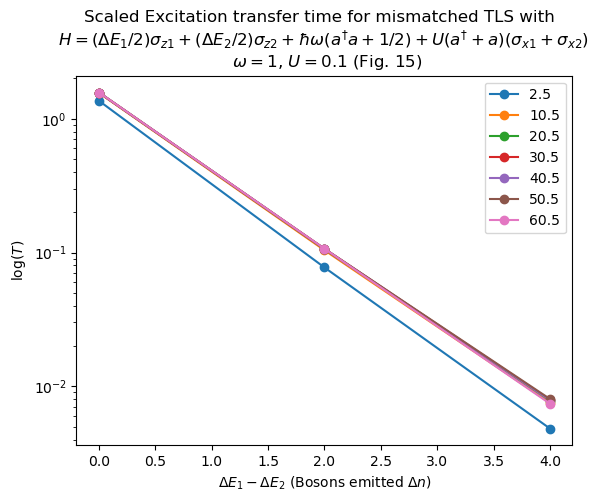

In [765]:
ax = scaled_transfer_times_df.plot(x="bosons", logy = True, title=f"Scaled Excitation transfer time for mismatched TLS with  \n {H_latex} \n $\omega=1$, $U=0.1$ (Fig. 15)", legend=True, style='o-');
ax.set_xlabel("$\Delta E_1 - \Delta E_2$ (Bosons emitted $\Delta n$)");
ax.set_ylabel("$\log(T)$");
plt.annotate('$\Delta E_2$', xy=(0.15, 1.2*10**3));

Looks like we've overcompensated in Fig. 15. At this point, we could start getting more systematic to find the best coefficients in our model. If we look again at the 2008 work of [Hagelstein](http://dx.doi.org/10.1088/0953-4075/41/13/135501), we find that all we're missing is a $\sqrt{8}$:

$$T \sim \left(\frac{\Delta E}{U\sqrt{8}}\right)^{2+\Delta n}$$


In [766]:
scaled_transfer_times_df = transfer_times_df.copy()

for index, row in scaled_transfer_times_df.iterrows():
    for DeltaE2 in DeltaE2s:
        scaled_transfer_times_df.loc[index, DeltaE2] /= ((DeltaE2+row["bosons"]+DeltaE2)/2/(np.sqrt(8)*U))**(2+row["bosons"])

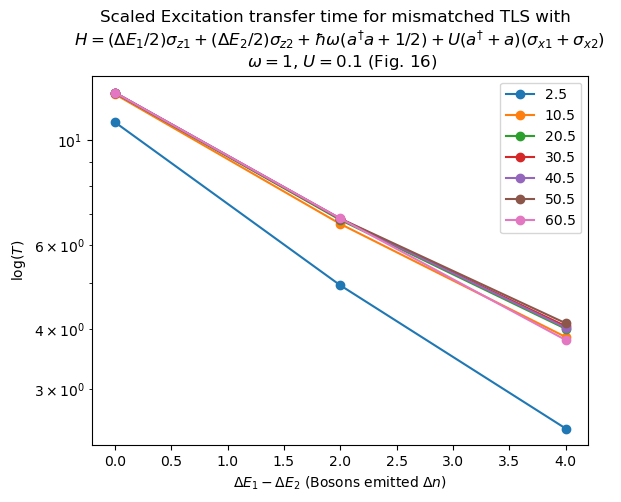

In [770]:
ax = scaled_transfer_times_df.plot(x="bosons", logy = True, title=f"Scaled Excitation transfer time for mismatched TLS with  \n {H_latex} \n $\omega=1$, $U=0.1$ (Fig. 16)", legend=True, style='o-');
ax.set_xlabel("$\Delta E_1 - \Delta E_2$ (Bosons emitted $\Delta n$)");
ax.set_ylabel("$\log(T)$");
plt.annotate('$\Delta E_2$', xy=(0.15, 1.2*10**3));

Of the 14 orders of magnitude difference that we saw in Fig 13, our model for the scaling of excitation transfer time explains 13 of them. This is not bad considering that the analytical work of Hagelstein works on the assumption of a highly excited oscillator (i.e, lots of bosons already present in the system) which we didn't have in our simulations.

What can we take away from the scalings we've found for excitation transfer time? If we don't have identical systems, then it's going to be very hard for us to observe excitation transfer due to the exponential scaling with TLS transition energy mismatch - it will just be too slow. Even with identical systems, the quadratic scaling with $\Delta E / U$ is also likely to make observing excitation transfer difficult because typically $\Delta E \gg U$.

## Next up...
Today, we've gone a bit deeper into excitation transfer and discovered that although it seems cool and exciting, it might not be something ever realised in the physical world due to how slow it seems to be.

However, we're not yet finished with our quantum wizardry 🧙‍♂️. There are several ways of speeding up quantum processes and so we're going to explore that next.

Until then. 👋